<a href="https://colab.research.google.com/github/ivanadj3/MIEP/blob/main/MIASKonacni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Adadelta optimizer

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from sklearn.utils.class_weight import compute_class_weight
import shutil

img_height, img_width = 224, 224
batch_size = 16
num_classes = 4

dataset_dir = '/content/drive/MyDrive/MIAS/all-mias'
output_dir = '/content/drive/MyDrive/MIAS/mias-processed'


train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Kreiranje poddirektorijuma za svaku klasu

classes = ['A', 'B', 'C', 'D']
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

# Listanje i etiketiranje fajlova

file_paths = []
file_labels = []

for filename in os.listdir(dataset_dir):
    if filename.endswith('.pgm') and filename.startswith('mdb'):
        file_number = int(filename[3:6])

        if file_number % 4 == 0:
            class_label = 'A'
        elif file_number % 4 == 1:
            class_label = 'B'
        elif file_number % 4 == 2:
            class_label = 'C'
        else:
            class_label = 'D'

        file_paths.append(os.path.join(dataset_dir, filename))
        file_labels.append(class_label)

train_files, test_files, train_labels, test_labels = train_test_split(file_paths, file_labels, test_size=0.2, stratify=file_labels, random_state=42)

# Kopiranje fajlova u odgovarajuće foldere

for file, label in zip(train_files, train_labels):
    dst = os.path.join(train_dir, label, os.path.basename(file))
    shutil.copyfile(file, dst)

for file, label in zip(test_files, test_labels):
    dst = os.path.join(test_dir, label, os.path.basename(file))
    shutil.copyfile(file, dst)

print("Slike su uspešno podeljene i kopirane u odgovarajuće direktorijume.")

Slike su uspešno podeljene i kopirane u odgovarajuće direktorijume.


In [3]:
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

classes = ['A', 'B', 'C', 'D']

def pgm_to_rgb(pgm_image_path):
    pgm_image = cv2.imread(pgm_image_path, cv2.IMREAD_GRAYSCALE)
    rgb_image = cv2.cvtColor(pgm_image, cv2.COLOR_GRAY2RGB)
    return rgb_image

file_paths = []
file_labels = []

for filename in os.listdir(dataset_dir):
    if filename.endswith('.pgm') and filename.startswith('mdb'):
        file_number = int(filename[3:6])
        class_label = classes[file_number % 4]

        file_paths.append(os.path.join(dataset_dir, filename))
        file_labels.append(class_label)

train_files, test_files, train_labels, test_labels = train_test_split(file_paths, file_labels, test_size=0.2, stratify=file_labels, random_state=42)

def convert_and_save_images(files, labels, output_directory):
    for file, label in zip(files, labels):
        dst = os.path.join(output_directory, label, os.path.basename(file).replace('.pgm', '.jpg'))
        rgb_image = pgm_to_rgb(file)
        cv2.imwrite(dst, rgb_image)

convert_and_save_images(train_files, train_labels, train_dir)
convert_and_save_images(test_files, test_labels, test_dir)


train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer = Adadelta(learning_rate=1.0), loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('/content/drive/My Drive/breast_density_model_v2.keras', save_best_only=True),
]

Found 257 images belonging to 4 classes.
Found 65 images belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.2133 - loss: 1.4877 - val_accuracy: 0.1875 - val_loss: 1.3855
Epoch 2/15
 1/16 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.3125 - loss: 1.3753

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.3125 - loss: 1.3753 - val_accuracy: 0.0000e+00 - val_loss: 1.3130
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.2248 - loss: 1.3908 - val_accuracy: 0.1719 - val_loss: 1.3902
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0000e+00 - loss: 1.4601 - val_accuracy: 0.0000e+00 - val_loss: 1.4060
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.2426 - loss: 1.3884 - val_accuracy: 0.2188 - val_loss: 1.3886
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3750 - loss: 1.3804 - val_accuracy: 0.0000e+00 - val_loss: 1.3699
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.2275 - loss: 1.3918 - val_accuracy: 0.2500 - val_loss: 1.3852


Manually shuffling the data:

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from sklearn.utils.class_weight import compute_class_weight

img_height, img_width = 224, 224
batch_size = 8
num_classes = 4

dataset_dir = '/content/drive/MyDrive/MIAS/all-mias'
output_dir = '/content/drive/MyDrive/MIAS/mias-processed'

train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

classes = ['A', 'B', 'C', 'D']

def pgm_to_rgb(pgm_image_path):
    pgm_image = cv2.imread(pgm_image_path, cv2.IMREAD_GRAYSCALE)
    rgb_image = cv2.cvtColor(pgm_image, cv2.COLOR_GRAY2RGB)
    return rgb_image

file_paths = []
file_labels = []

for filename in os.listdir(dataset_dir):
    if filename.endswith('.pgm') and filename.startswith('mdb'):
        file_number = int(filename[3:6])
        class_label = classes[file_number % 4]
        file_paths.append(os.path.join(dataset_dir, filename))
        file_labels.append(class_label)

train_files, test_files, train_labels, test_labels = train_test_split(
    file_paths, file_labels, test_size=0.2, stratify=file_labels, random_state=42)

# Shuffle training data manually
train_data = list(zip(train_files, train_labels))
np.random.shuffle(train_data)
train_files, train_labels = zip(*train_data)

def convert_and_save_images(files, labels, output_directory):
    for file, label in zip(files, labels):
        dst = os.path.join(output_directory, label, os.path.basename(file).replace('.pgm', '.jpg'))
        rgb_image = pgm_to_rgb(file)
        cv2.imwrite(dst, rgb_image)

convert_and_save_images(train_files, train_labels, train_dir)
convert_and_save_images(test_files, test_labels, test_dir)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True # Keep shuffle to True
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False # No need to shuffle validation data
)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer = Adadelta(learning_rate=1.0), loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('/content/drive/My Drive/breast_density_model_v2.keras', save_best_only=True),
]

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=callbacks
)


Found 257 images belonging to 4 classes.
Found 65 images belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.2060 - loss: 1.4480 - val_accuracy: 0.2462 - val_loss: 1.3847
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.2416 - loss: 1.3909 - val_accuracy: 0.3538 - val_loss: 1.3860
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.2001 - loss: 1.3911 - val_accuracy: 0.2154 - val_loss: 1.3866
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.2623 - loss: 1.3884 - val_accuracy: 0.2462 - val_loss: 1.3862
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.2858 - loss: 1.3873 - val_accuracy: 0.4615 - val_loss: 1.3861
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.2877 - loss: 1.3867 - val_accuracy: 0.4154 - val_loss: 1.3821
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.2154 - loss: 1.3896 - val_accuracy: 0.2308 - val_loss: 1.3866
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.2264 - loss: 1.3877 - val_accuracy: 0.2308 - val_loss: 1.3864
Epo

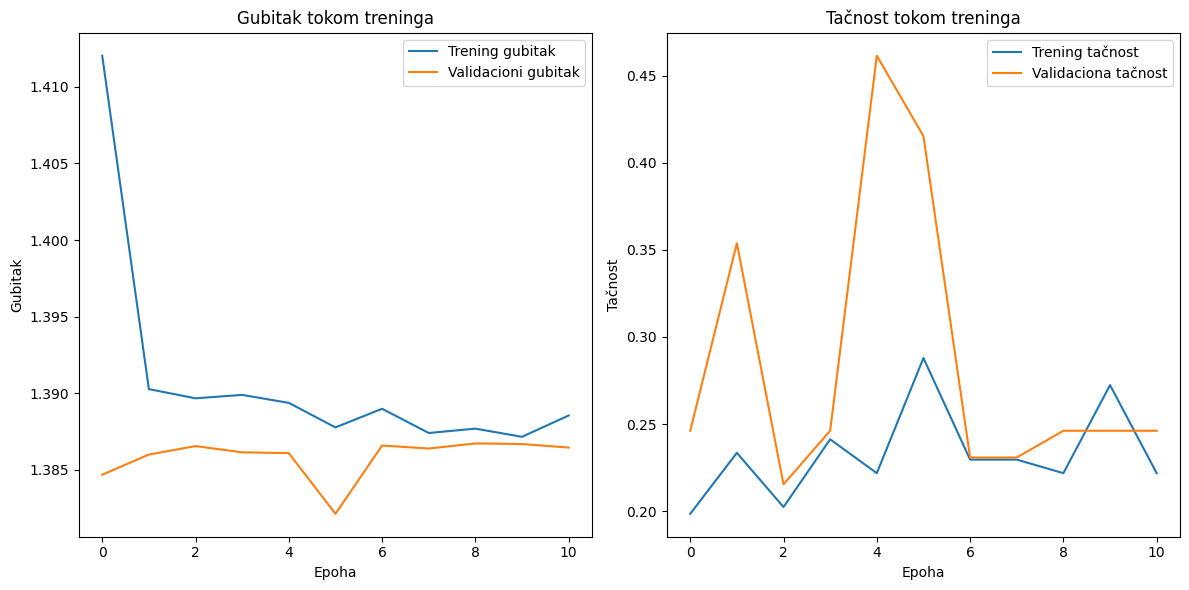

In [6]:
def plot_training(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Trening gubitak')
    plt.plot(history.history['val_loss'], label='Validacioni gubitak')
    plt.xlabel('Epoha')
    plt.ylabel('Gubitak')
    plt.title('Gubitak tokom treninga')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Trening tačnost')
    plt.plot(history.history['val_accuracy'], label='Validaciona tačnost')
    plt.xlabel('Epoha')
    plt.ylabel('Tačnost')
    plt.title('Tačnost tokom treninga')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training(history)